# Notebook to make Fig. 5

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde

import json
import random
import sys
import os

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from helper_functions import *

style.use('plotting.mplstyle')

### Load data

This data is calculated in `make_figure_04.ipynb` and is prerequesite for this notebook.

In [2]:
if os.path.exists('predicted_spins_dict_pp.json') and os.path.exists('observed_spins_dict_pp.json'): 
    
    # Load in the predicted and observed draws 
    with open('predicted_spins_dict_pp.json', 'r') as f: 
        pred_spins = json.load(f)
    with open('observed_spins_dict_pp.json', 'r') as f: 
        obs_spins = json.load(f)

else: 
    print('Go to make_figure_04.ipynb notebook to generate predicted_spins_dict_pp.json and observed_spins_dict_pp.json')

### Calculate slopes of PP plot (Fig 4) for each catalog as a function of predicted spin

Calculate slopes using linear regression

In [3]:
# Function to do basic linear regression with matrix multiplication 
def findSlope(x_values, y_values): 
    
    X = np.asarray([[x, 1] for x in x_values])
    X_T = np.transpose(X)
        
    X_matrix = np.matmul(np.linalg.inv(np.matmul(X_T, X)), X_T)
    
    slope, intercept = np.matmul(X_matrix, y_values)
    
    return slope

In [4]:
# number of trials we want to break all the catalogs into in order to calculate error bars
nTrials = 10 

# dictionary to stores slopes and x-values i n
slopes_dict = {}

# Cycle through populations
for pop_key in ['pop1', 'pop2', 'pop3']: 
    
    print(pop_key)
    
    slopes_dict_pop = {}
    
    # Cycle through parameters
    for param_key in ['chi1', 'cost1', 'chieff', 'chip']:  ## TODO change to chi, cost, chieff, chip
        
        # Array in which to store slopes and corresponding 'x' values
        nCatalogs, nEvents = np.asarray(pred_spins[pop_key][param_key]).shape
        nCut = 4 # amount to cut off from ends for linear regression
        if param_key=='chi1' or param_key=='cost1': # combine chi1 + chi2, and cost1 +cost2
            nXVals = 2*nEvents - nCut
        else: 
            nXVals = nEvents - nCut
        slopes = np.zeros((nCatalogs, nXVals))
        x_vals = np.zeros((nCatalogs, nXVals))
        
        # Cycle through catalogs
        for i in range(nCatalogs): 
            
            # Sort spins
            if param_key=='chi1' or param_key=='cost1': 
                # combine chi1 + chi2, and cost1 +cost2
                pred_spins_arr = np.sort(np.concatenate((pred_spins[pop_key][param_key][i], pred_spins[pop_key][param_key[:-1]+'2'][i])))
                obs_spins_arr = np.sort(np.concatenate((obs_spins[pop_key][param_key][i], obs_spins[pop_key][param_key[:-1]+'2'][i])))
            else:
                pred_spins_arr = np.sort(pred_spins[pop_key][param_key][i])
                obs_spins_arr = np.sort(obs_spins[pop_key][param_key][i])
            
            # Calculate slopes
            x_vals[i,:] = pred_spins_arr[int(nCut/2):-int(nCut/2)]
            slopes[i,:] = [findSlope(pred_spins_arr[j:j+nCut], obs_spins_arr[j:j+nCut]) for j in range(nXVals)]
        
        # shape into proper form
        slopes_dict_pop[param_key] = {
            'slopes':np.reshape(slopes, (nTrials, int(nCatalogs/nTrials), nXVals)),
            'x_vals':np.reshape(x_vals, (nTrials, int(nCatalogs/nTrials), nXVals)) 
        }
        
    slopes_dict[pop_key] = slopes_dict_pop
    
print('Done!')

pop1
pop2
pop3
Done!


Calculate percentages of slopes above versus below 1

In [5]:
percentages_dict = {}

for pop,pop_key in enumerate(['pop1', 'pop2', 'pop3']):
    
    print(pop_key)
    
    percentages_dict_pop = {}
    
    for param_key in ['chi1', 'cost1', 'chieff', 'chip']: 
        
        # Gets slopes and x vals for this population and parameters
        slopes = slopes_dict[pop_key][param_key]['slopes']
        all_x_vals = slopes_dict[pop_key][param_key]['x_vals']
    
        # Binning
        all_x = np.concatenate(np.concatenate(all_x_vals))
        xmin = np.min(all_x)
        xmax = np.max(all_x)
        xbins = np.linspace(xmin, xmax, 50)
        
        # Cycle through trials, each has it's own set of y values
        percentages_all = []
        
        for j in range(nTrials): 
            
            all_y = np.concatenate(slopes[j])
            all_x_this = np.concatenate(all_x_vals[j])

            # Calculate fraction in each bin above the line x=1
            percentages = []
            midpoints = []
            for i in np.arange(len(xbins)-1):

                lower_bound = xbins[i]
                upper_bound = xbins[i+1]
                mask = (all_x_this >= lower_bound) & (all_x_this <= upper_bound)
                x_vals = all_x_this[mask]
                y_vals = all_y[mask]

                # percentage of values below y=x, ignoring the points with only a few traces (< 5 % of catalogs)
                if len(x_vals) >= int(0.05*nCatalogs): 
                    percentages += [sum(y_vals < 1) / len(x_vals)]
                else: 
                    percentages += [np.inf] # will ignore when averaging

                # midpoint of bin
                midpoints += [0.5*(lower_bound+upper_bound)]
                                    
            percentages_all.append(percentages)     
       
        # get mean and std dev across trials
        per_transpose = np.transpose(percentages_all)
        means = np.zeros(len(midpoints))
        stds = np.zeros(len(midpoints))
        for i in np.arange(len(midpoints)): 
            mask = (per_transpose[i] != np.inf)
            per = per_transpose[i][mask]
            means[i] = np.mean(per)
            stds[i] = np.std(per)
        
        # make dict
        percentages_dict_pop[param_key] = {'percentages':means, 'error':stds, 'x_vals':np.asarray(midpoints)}
        
    percentages_dict[pop_key] = percentages_dict_pop
    
print('Done!')

pop1
pop2


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_met

pop3
Done!


### Make figure

In [6]:
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

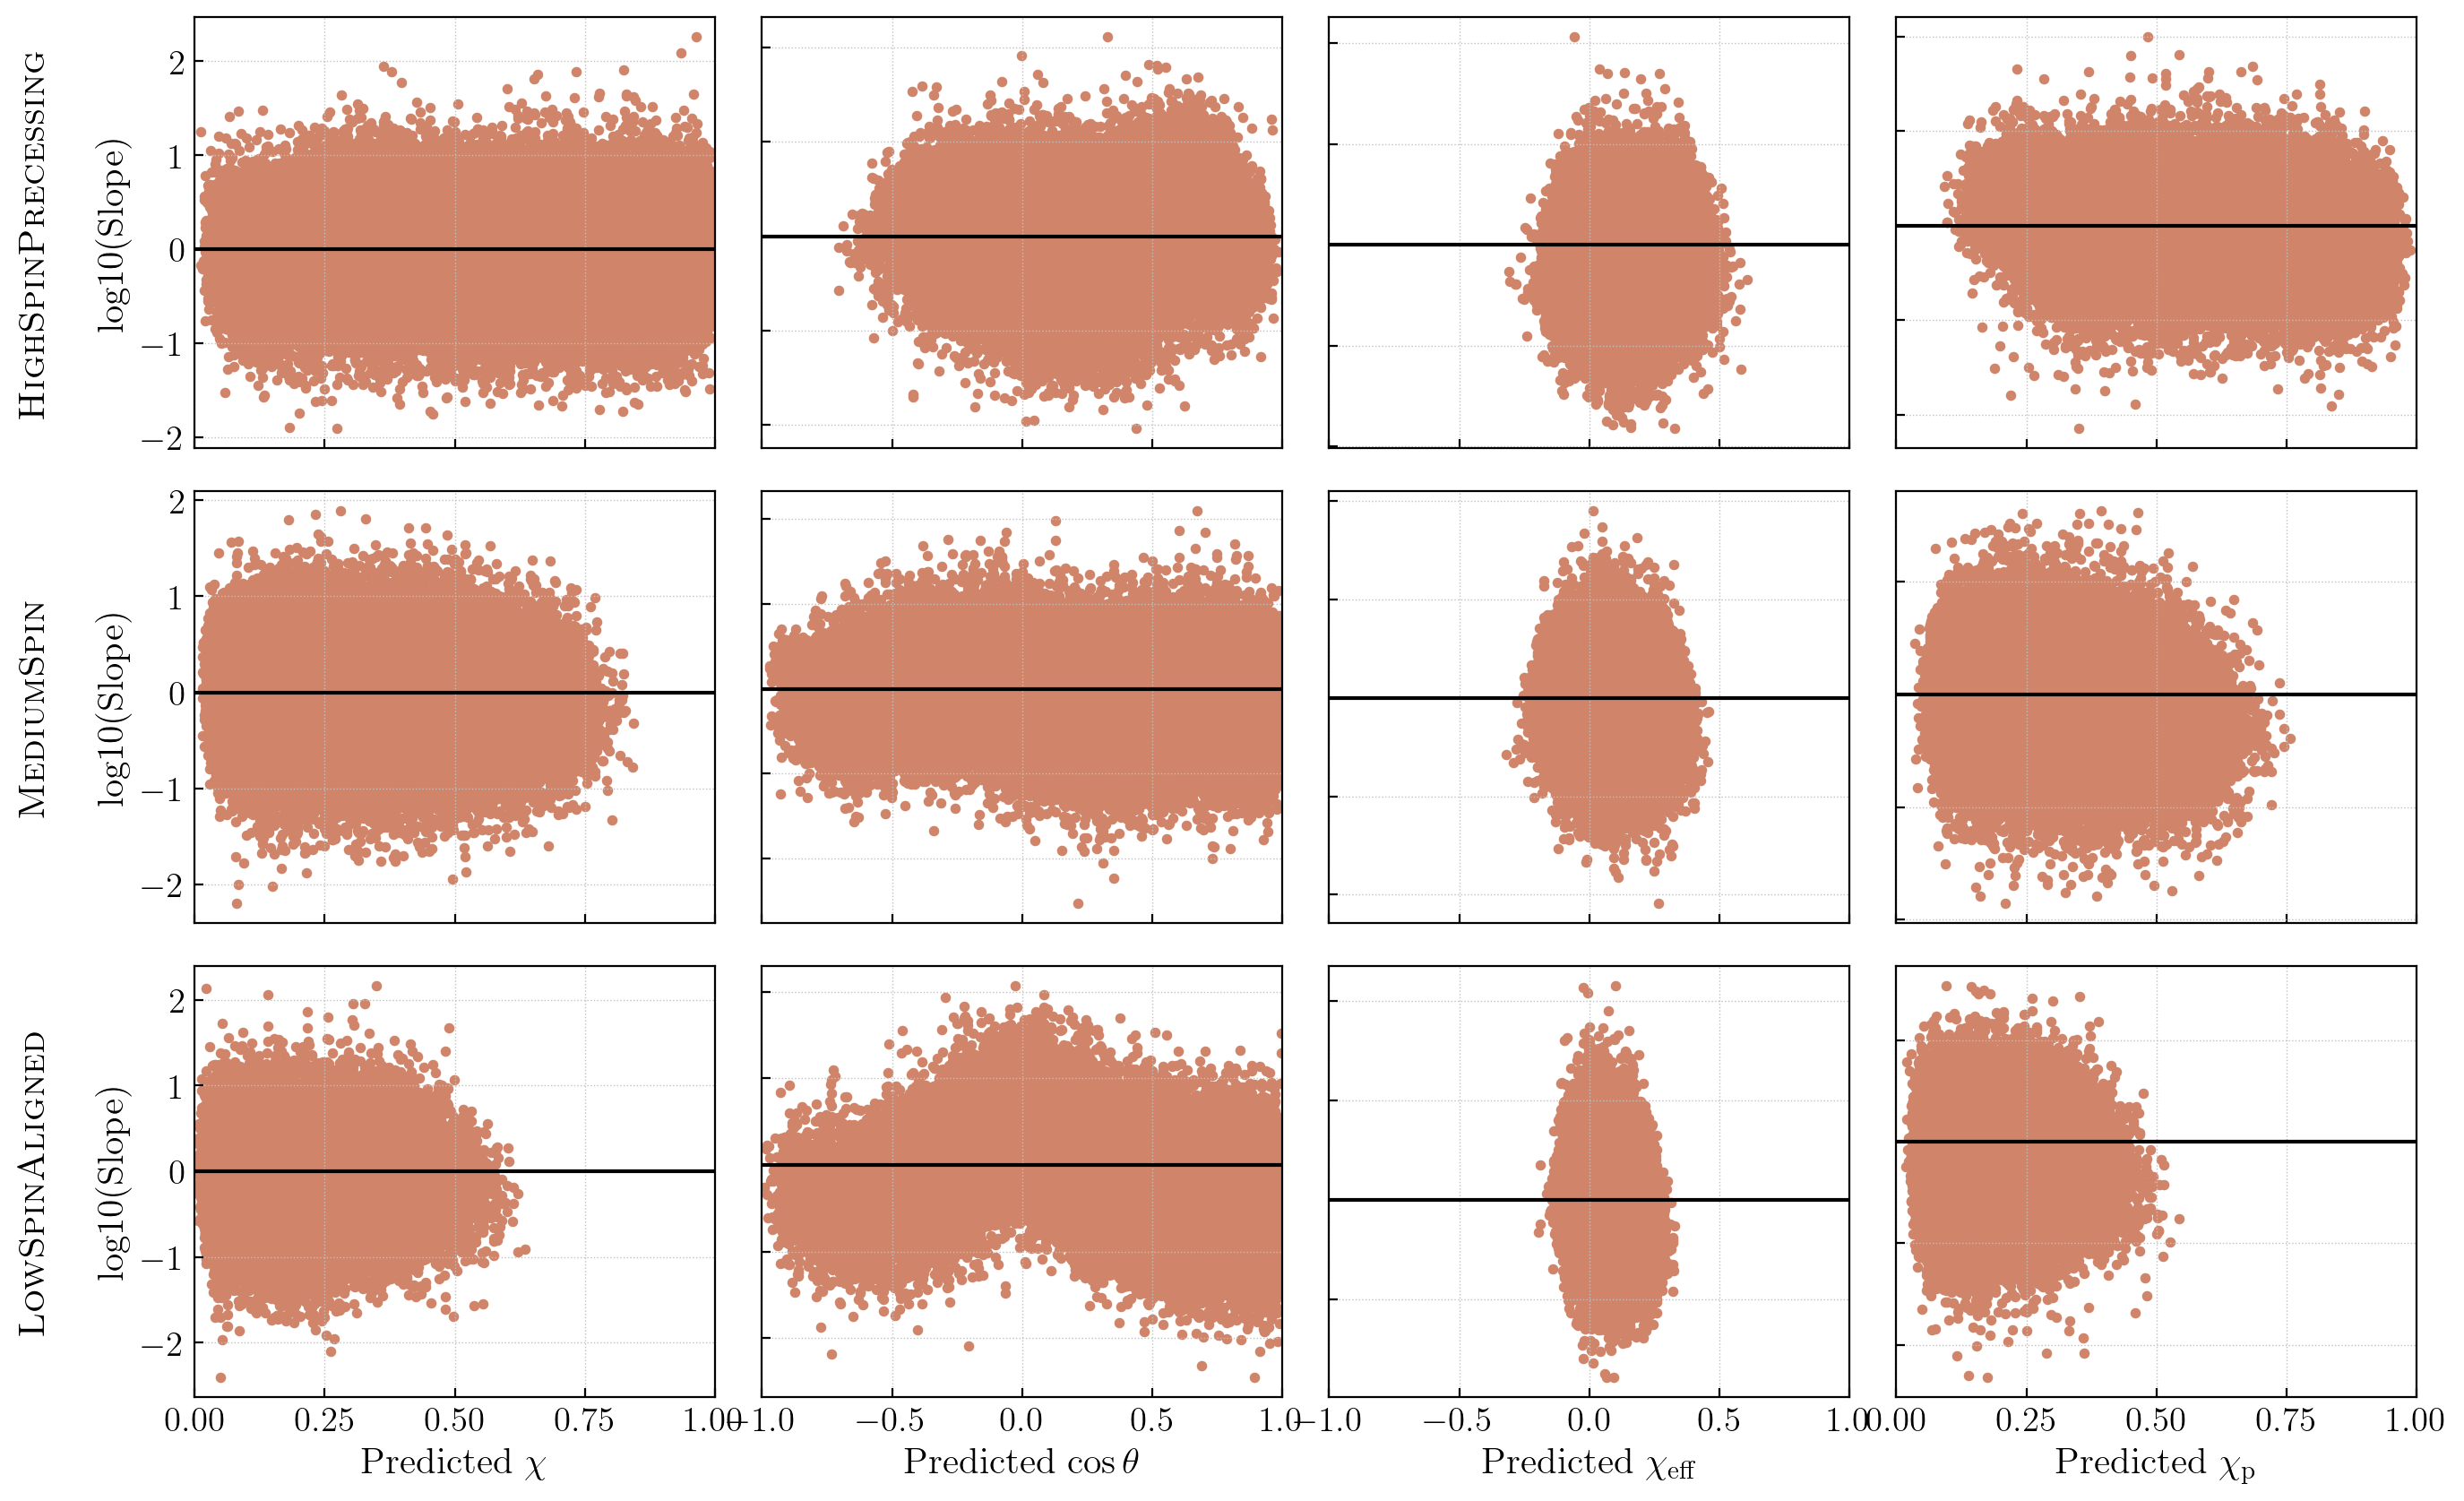

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(['pop1', 'pop2', 'pop3']):
    
    # spin magnitudes
    axes[i][0].scatter(slopes_dict[key]['chi1']['x_vals'], np.log10(slopes_dict[key]['chi1']['slopes']), s=10, color='#d0856a')
    axes[i][0].plot([0, 1], [0, 0], color='k') # horizontal line
    axes[i][0].set_xlim(0,1)
    #axes[i][0].set_ylim(0,1)
    
    # tilt angles
    axes[i][1].scatter(slopes_dict[key]['cost1']['x_vals'], np.log10(slopes_dict[key]['cost1']['slopes']), s=10, color='#d0856a')
    axes[i][1].plot([-1, 1], [0, 0], color='k')
    axes[i][1].set_xlim(-1,1)
    #axes[i][1].set_ylim(0,1)
    
    # chi eff
    axes[i][2].scatter(slopes_dict[key]['chieff']['x_vals'], np.log10(slopes_dict[key]['chieff']['slopes']), s=10, color='#d0856a')
    axes[i][2].plot([-1, 1], [0, 0], color='k')
    axes[i][2].set_xlim(-1,1)
    #axes[i][2].set_ylim(0,1)
    
    # chi p
    axes[i][3].scatter(slopes_dict[key]['chip']['x_vals'], np.log10(slopes_dict[key]['chip']['slopes']), s=10, color='#d0856a')
    axes[i][3].plot([0, 1], [0, 0], color='k')
    axes[i][3].set_xlim(0,1)
    #axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n log10(Slope)', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Predicted $\chi$', fontsize=15)
axes[2][1].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
axes[2][2].set_xlabel(r'Predicted $\chi_\mathrm{eff}$', fontsize=15)
axes[2][3].set_xlabel(r'Predicted $\chi_\mathrm{p}$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
    
plt.show()

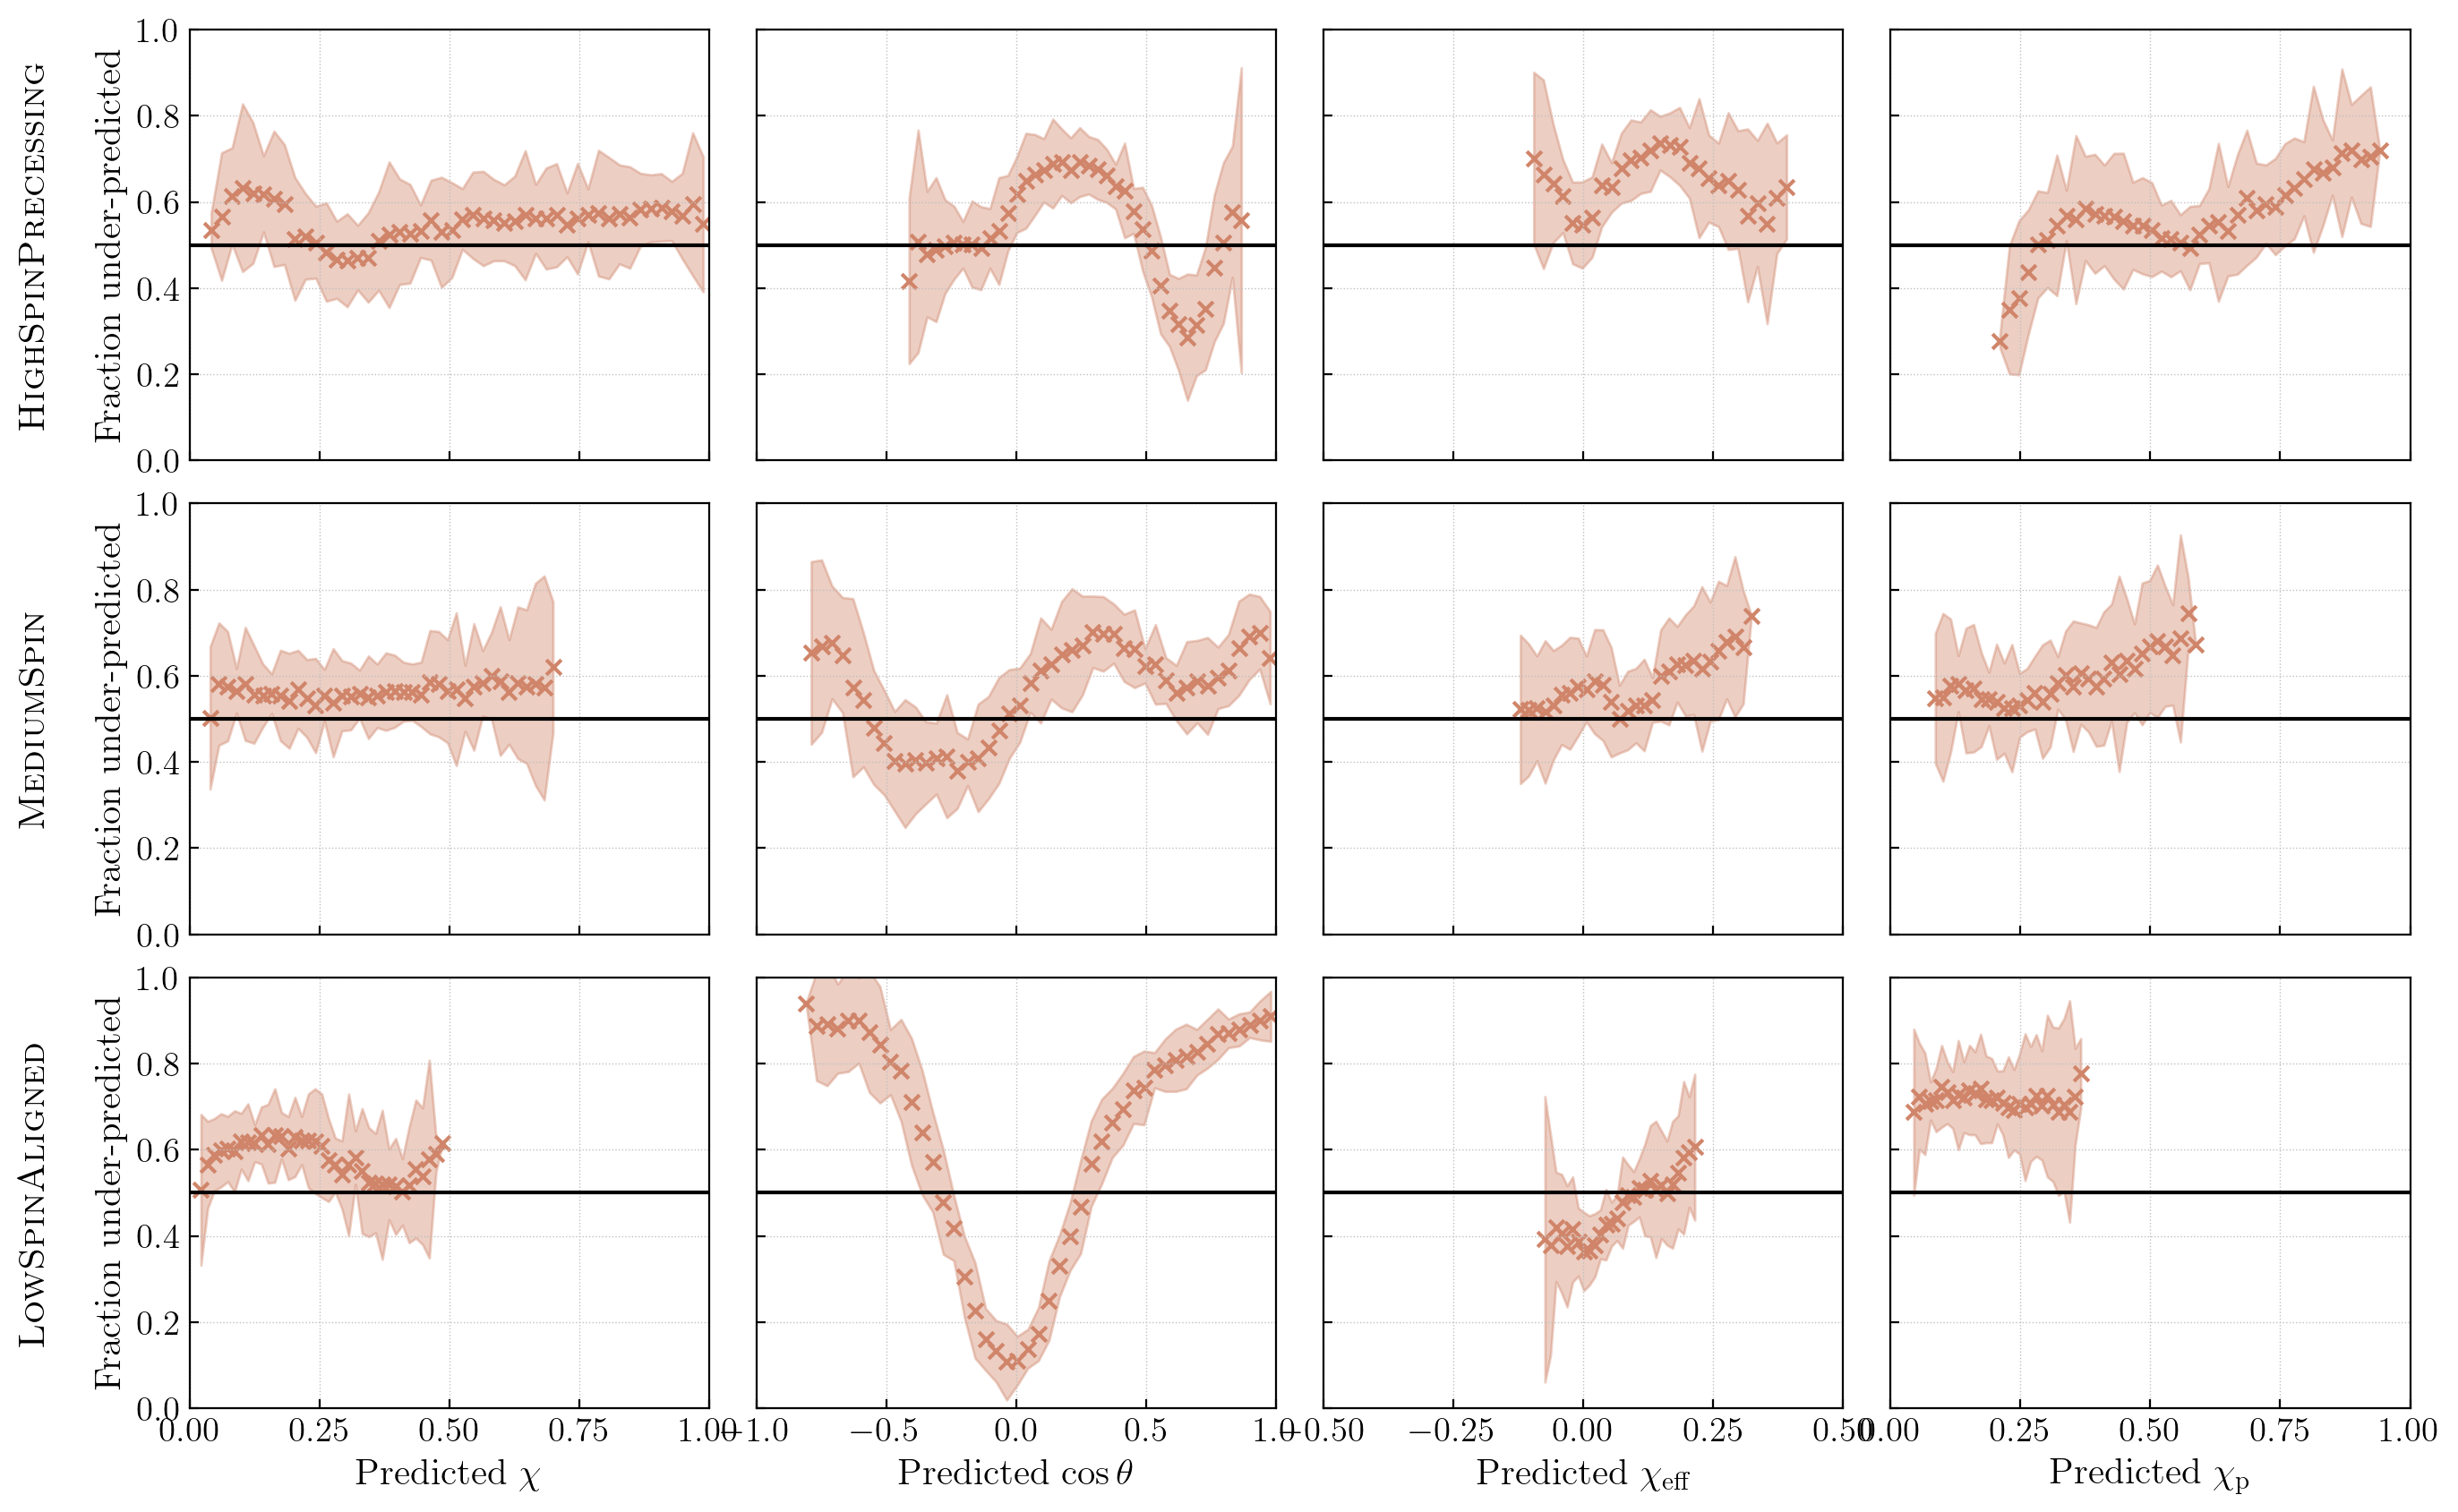

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(['pop1', 'pop2', 'pop3']):
    
    # spin magnitudes
    axes[i][0].scatter(percentages_dict[key]['chi1']['x_vals'], percentages_dict[key]['chi1']['percentages'], color='#d0856a', marker='x')
    axes[i][0].fill_between(percentages_dict[key]['chi1']['x_vals'], 
                            percentages_dict[key]['chi1']['percentages']+3*percentages_dict[key]['chi1']['error'], 
                            percentages_dict[key]['chi1']['percentages']-3*percentages_dict[key]['chi1']['error'], 
                            color='#d0856a', alpha=0.4)
    axes[i][0].plot([0, 1], [0.5, 0.5], color='k') # horizontal line
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,1)
    
    # tilt angles
    axes[i][1].scatter(percentages_dict[key]['cost1']['x_vals'], percentages_dict[key]['cost1']['percentages'], color='#d0856a', marker='x')
    axes[i][1].fill_between(percentages_dict[key]['cost1']['x_vals'], 
                            percentages_dict[key]['cost1']['percentages']+3*percentages_dict[key]['cost1']['error'], 
                            percentages_dict[key]['cost1']['percentages']-3*percentages_dict[key]['cost1']['error'], 
                            color='#d0856a', alpha=0.4)
    axes[i][1].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][1].set_xlim(-1,1)
    axes[i][1].set_ylim(0,1)
    
    # chi eff
    axes[i][2].scatter(percentages_dict[key]['chieff']['x_vals'], percentages_dict[key]['chieff']['percentages'], color='#d0856a', marker='x')
    axes[i][2].fill_between(percentages_dict[key]['chieff']['x_vals'], 
                            percentages_dict[key]['chieff']['percentages']+3*percentages_dict[key]['chieff']['error'], 
                            percentages_dict[key]['chieff']['percentages']-3*percentages_dict[key]['chieff']['error'], 
                            color='#d0856a', alpha=0.4)
    axes[i][2].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][2].set_xlim(-0.5,0.5)
    axes[i][2].set_ylim(0,1)
    
    # chi p
    axes[i][3].scatter(percentages_dict[key]['chip']['x_vals'], percentages_dict[key]['chip']['percentages'], color='#d0856a', marker='x')
    axes[i][3].fill_between(percentages_dict[key]['chip']['x_vals'], 
                            percentages_dict[key]['chip']['percentages']+3*percentages_dict[key]['chip']['error'], 
                            percentages_dict[key]['chip']['percentages']-3*percentages_dict[key]['chip']['error'], 
                            color='#d0856a', alpha=0.4)
    axes[i][3].plot([0, 1], [0.5, 0.5], color='k')
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n Fraction under-predicted', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Predicted $\chi$', fontsize=15)
axes[2][1].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
axes[2][2].set_xlabel(r'Predicted $\chi_\mathrm{eff}$', fontsize=15)
axes[2][3].set_xlabel(r'Predicted $\chi_\mathrm{p}$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
    
#plt.savefig('figure_05_temp.pdf',bbox_inches='tight')
plt.show()

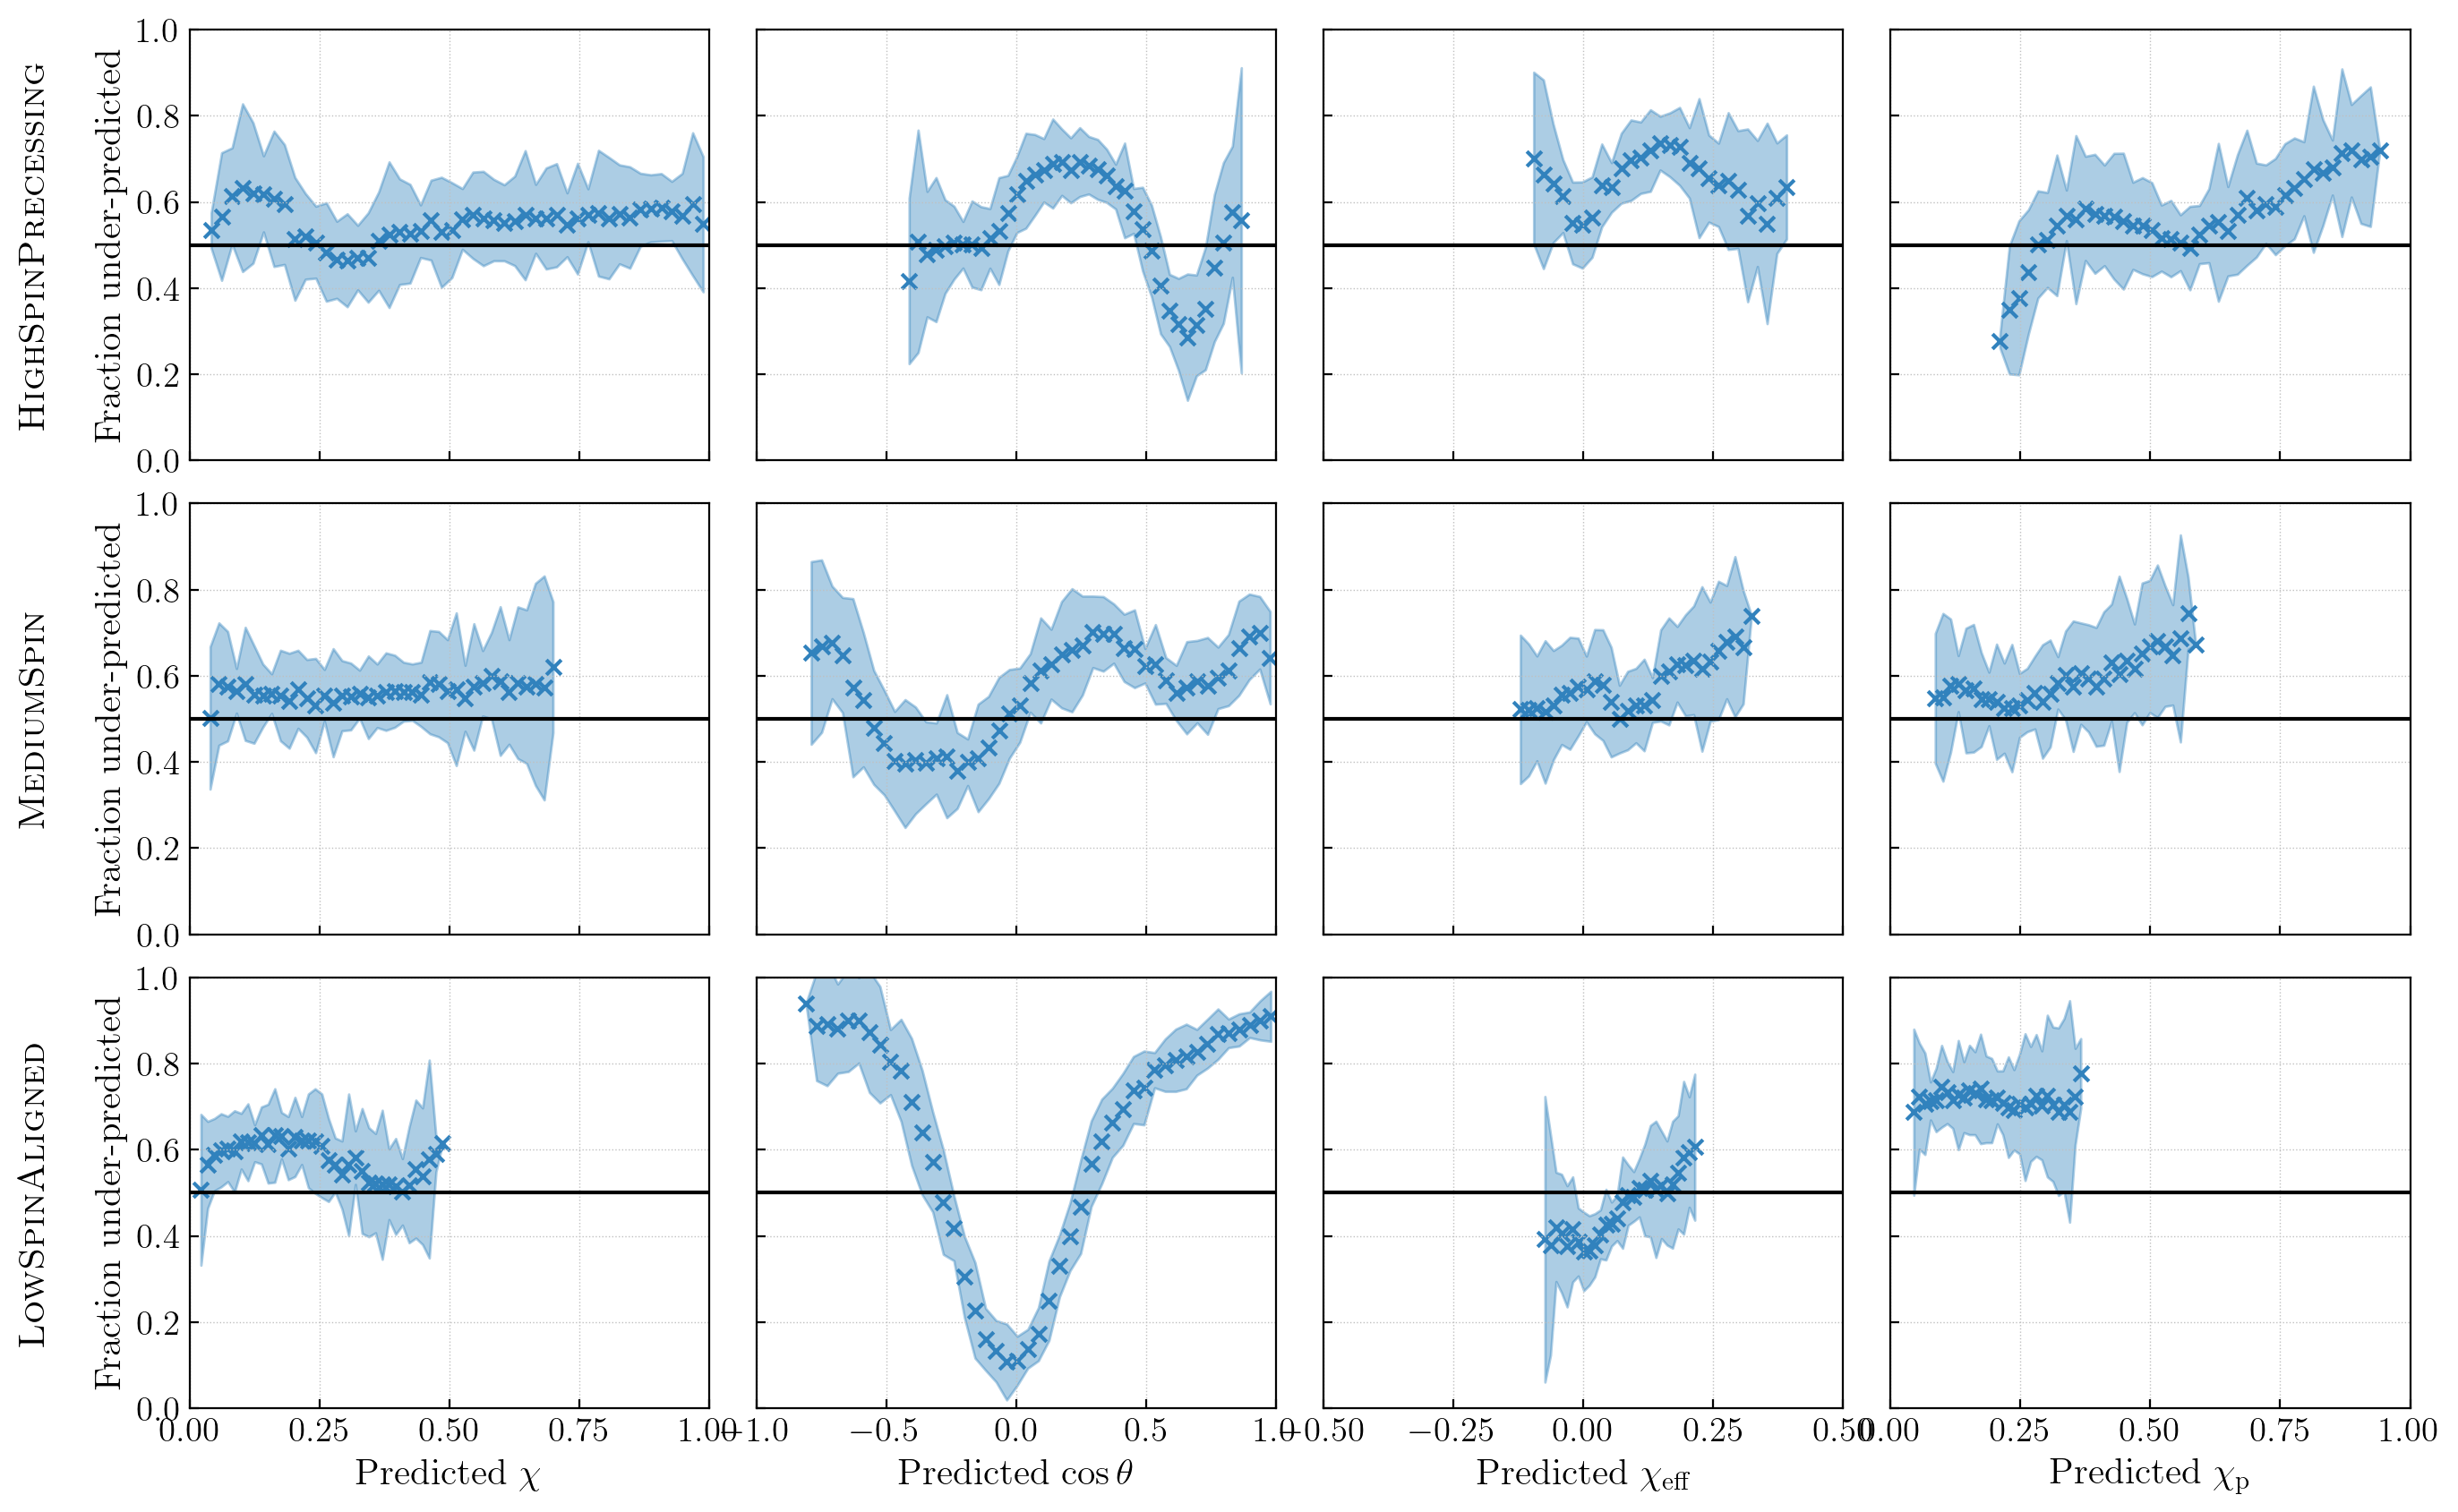

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(['pop1', 'pop2', 'pop3']):
    
    # spin magnitudes
    axes[i][0].scatter(percentages_dict[key]['chi1']['x_vals'], percentages_dict[key]['chi1']['percentages'], color='#3182bd', marker='x')
    axes[i][0].fill_between(percentages_dict[key]['chi1']['x_vals'], 
                            percentages_dict[key]['chi1']['percentages']+3*percentages_dict[key]['chi1']['error'], 
                            percentages_dict[key]['chi1']['percentages']-3*percentages_dict[key]['chi1']['error'], 
                            color='#3182bd', alpha=0.4)
    axes[i][0].plot([0, 1], [0.5, 0.5], color='k') # horizontal line
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,1)
    
    # tilt angles
    axes[i][1].scatter(percentages_dict[key]['cost1']['x_vals'], percentages_dict[key]['cost1']['percentages'], color='#3182bd', marker='x')
    axes[i][1].fill_between(percentages_dict[key]['cost1']['x_vals'], 
                            percentages_dict[key]['cost1']['percentages']+3*percentages_dict[key]['cost1']['error'], 
                            percentages_dict[key]['cost1']['percentages']-3*percentages_dict[key]['cost1']['error'], 
                            color='#3182bd', alpha=0.4)
    axes[i][1].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][1].set_xlim(-1,1)
    axes[i][1].set_ylim(0,1)
    
    # chi eff
    axes[i][2].scatter(percentages_dict[key]['chieff']['x_vals'], percentages_dict[key]['chieff']['percentages'], color='#3182bd', marker='x')
    axes[i][2].fill_between(percentages_dict[key]['chieff']['x_vals'], 
                            percentages_dict[key]['chieff']['percentages']+3*percentages_dict[key]['chieff']['error'], 
                            percentages_dict[key]['chieff']['percentages']-3*percentages_dict[key]['chieff']['error'], 
                            color='#3182bd', alpha=0.4)
    axes[i][2].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][2].set_xlim(-0.5,0.5)
    axes[i][2].set_ylim(0,1)
    
    # chi p
    axes[i][3].scatter(percentages_dict[key]['chip']['x_vals'], percentages_dict[key]['chip']['percentages'], color='#3182bd', marker='x')
    axes[i][3].fill_between(percentages_dict[key]['chip']['x_vals'], 
                            percentages_dict[key]['chip']['percentages']+3*percentages_dict[key]['chip']['error'], 
                            percentages_dict[key]['chip']['percentages']-3*percentages_dict[key]['chip']['error'], 
                            color='#3182bd', alpha=0.4)
    axes[i][3].plot([0, 1], [0.5, 0.5], color='k')
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n Fraction under-predicted', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Predicted $\chi$', fontsize=15)
axes[2][1].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
axes[2][2].set_xlabel(r'Predicted $\chi_\mathrm{eff}$', fontsize=15)
axes[2][3].set_xlabel(r'Predicted $\chi_\mathrm{p}$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
plt.show()